# Clustering Client

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:50092")
client

Client Scheduler: tcp://127.0.0.1:50092 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


In [2]:
import dask.array as da
import dask.dataframe as dd
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn import decomposition
from sklearn import manifold
from sklearn import metrics
from dask_ml import preprocessing

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
%matplotlib inline

## 1 - Import des jeux de données

In [4]:
data_3_months = dd.read_csv("data/clean/data_3_months.csv", parse_dates=["order_purchase_timestamp"])
data_6_months = dd.read_csv("data/clean/data_6_months.csv", parse_dates=["order_purchase_timestamp"])
data_9_months = dd.read_csv("data/clean/data_9_months.csv", parse_dates=["order_purchase_timestamp"])
data_12_months = dd.read_csv("data/clean/data_12_months.csv", parse_dates=["order_purchase_timestamp"])
data_15_months = dd.read_csv("data/clean/data_15_months.csv", parse_dates=["order_purchase_timestamp"])
data_18_months = dd.read_csv("data/clean/data_18_months.csv", parse_dates=["order_purchase_timestamp"])
data_all = dd.read_csv("data/clean/data_all.csv", parse_dates=["order_purchase_timestamp"])

## 2 - Features engineering

In [5]:
def review(df):
    grouped = df.groupby("customer_unique_id").agg({"review_score": ["count", "min", "max", "mean"]})
    grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
    return grouped

def value(df):
    grouped = df.groupby("customer_unique_id").agg({
        "payment_value": ["mean", "min", "max"]})
    grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
    return grouped

def payment_facility(df):
    df_pf = df.groupby("customer_unique_id").agg({
        "payment_installments": "sum"
    })
    cond_mask = (df_pf["payment_installments"] > 1)

    df_pf["payment_installments"] = df_pf["payment_installments"].mask(cond=cond_mask, other=0)
    df_pf = df_pf.rename(columns={"payment_installments": "payment_facility"})
    return df_pf

def category_transf(df):
    df_ct = dd.get_dummies(df[["product_category_name", "customer_unique_id"]].categorize(), columns=['product_category_name'], prefix="PCat").groupby(['customer_unique_id']).sum()
    return df_ct

def state(df):
    df_state = dd.get_dummies(df[["customer_state", "customer_unique_id"]].categorize(), columns=["customer_state"], prefix="CState").groupby(["customer_unique_id"]).sum()
    return df_state

def payment(df):
    df_p = dd.get_dummies(df[["payment_type", "customer_unique_id"]].categorize(), columns=['payment_type'], prefix="PType").groupby(['customer_unique_id']).sum()
    return df_p

def rfm(df):
    df = df.compute()
    return df.groupby("customer_unique_id").agg(
        recency=("order_purchase_timestamp", lambda date: (df["order_purchase_timestamp"].max() - date.max()).days),
        frequency=("order_id", "count"),
        monetary=("payment_value", sum))

def features_engineering(df):
    df_fe = dd.merge(rfm(df), value(df))
    df_fe = dd.merge(df_fe, review(df))
    df_fe = dd.merge(df_fe, payment(df))
    df_fe = dd.merge(df_fe, state(df))
    df_fe = dd.merge(df_fe, category_transf(df))
    df_fe = dd.merge(df_fe, payment_facility(df))
    return df_fe

In [5]:
data_3_months_fe = features_engineering(data_3_months).compute()
data_3_months_fe.head()

,recency,frequency,monetary,payment_value_mean,payment_value_min,payment_value_max,review_score_count,review_score_min,review_score_max,review_score_mean,...,PCat_fashion_underwear_beach,PCat_books_technical,PCat_dvds_blu_ray,PCat_security_and_services,PCat_tablets_printing_image,PCat_furniture_bedroom,PCat_cine_photo,PCat_fashio_female_clothing,PCat_books_imported,payment_facility
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,20,1,86.22,86.22,86.22,86.22,1,3,3,3.0,...,0,0,0,0,0,0,0,0,0,0
0005e1862207bf6ccc02e4228effd9a0,26,1,150.12,150.12,150.12,150.12,1,4,4,4.0,...,0,0,0,0,0,0,0,0,0,0
00115fc7123b5310cf6d3a3aa932699e,68,1,76.11,76.11,76.11,76.11,1,4,4,4.0,...,0,0,0,0,0,0,0,0,0,1
001f3c4211216384d5fe59b041ce1461,11,1,35.84,35.84,35.84,35.84,1,3,3,3.0,...,0,0,0,0,0,0,0,0,0,0
002043098f10ba39a4600b6c52fbfe3c,4,1,237.81,237.81,237.81,237.81,1,4,4,4.0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
data_6_months_fe = features_engineering(data_6_months).compute()
data_6_months_fe.head()

,recency,frequency,monetary,payment_value_mean,payment_value_min,payment_value_max,review_score_count,review_score_min,review_score_max,review_score_mean,...,PCat_books_technical,PCat_dvds_blu_ray,PCat_security_and_services,PCat_tablets_printing_image,PCat_furniture_bedroom,PCat_cine_photo,PCat_fashio_female_clothing,PCat_books_imported,PCat_la_cuisine,payment_facility
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,111,1,86.22,86.22,86.22,86.22,1,3,3,3.0,...,0,0,0,0,0,0,0,0,0,0
0005e1862207bf6ccc02e4228effd9a0,116,1,150.12,150.12,150.12,150.12,1,4,4,4.0,...,0,0,0,0,0,0,0,0,0,0
00115fc7123b5310cf6d3a3aa932699e,159,1,76.11,76.11,76.11,76.11,1,4,4,4.0,...,0,0,0,0,0,0,0,0,0,1
0011805441c0d1b68b48002f1d005526,66,1,297.14,297.14,297.14,297.14,1,3,3,3.0,...,0,0,0,0,0,0,0,0,0,0
0011857aff0e5871ce5eb429f21cdaf5,1,1,192.83,192.83,192.83,192.83,1,5,5,5.0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
data_9_months_fe = features_engineering(data_9_months).compute()
data_9_months_fe.head()

,recency,frequency,monetary,payment_value_mean,payment_value_min,payment_value_max,review_score_count,review_score_min,review_score_max,review_score_mean,...,PCat_dvds_blu_ray,PCat_cds_dvds_musicals,PCat_security_and_services,PCat_tablets_printing_image,PCat_furniture_bedroom,PCat_cine_photo,PCat_fashio_female_clothing,PCat_books_imported,PCat_la_cuisine,payment_facility
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,203,1,86.22,86.22,86.22,86.22,1,3,3,3.0,...,0,0,0,0,0,0,0,0,0,0
0005e1862207bf6ccc02e4228effd9a0,209,1,150.12,150.12,150.12,150.12,1,4,4,4.0,...,0,0,0,0,0,0,0,0,0,0
0006fdc98a402fceb4eb0ee528f6a8d4,73,1,29.00,29.00,29.00,29.00,1,3,3,3.0,...,0,0,0,0,0,0,0,0,0,0
000a5ad9c4601d2bbdd9ed765d5213b3,49,1,91.28,91.28,91.28,91.28,1,4,4,4.0,...,0,0,0,0,0,0,0,0,0,0
000bfa1d2f1a41876493be685390d6d3,0,2,93.70,46.85,46.85,46.85,2,4,5,4.5,...,0,0,0,0,0,0,0,0,0,0


In [8]:
data_12_months_fe = features_engineering(data_12_months).compute()
data_12_months_fe.head()

,recency,frequency,monetary,payment_value_mean,payment_value_min,payment_value_max,review_score_count,review_score_min,review_score_max,review_score_mean,...,PCat_cds_dvds_musicals,PCat_security_and_services,PCat_tablets_printing_image,PCat_furniture_bedroom,PCat_cine_photo,PCat_fashio_female_clothing,PCat_diapers_and_hygiene,PCat_books_imported,PCat_la_cuisine,payment_facility
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,295,1,86.22,86.22,86.22,86.22,1,3,3,3.0,...,0,0,0,0,0,0,0,0,0,0
0000f6ccb0745a6a4b88665a16c9f078,79,1,43.62,43.62,43.62,43.62,1,4,4,4.0,...,0,0,0,0,0,0,0,0,0,0
0004aac84e0df4da2b147fca70cf8255,46,1,196.89,196.89,196.89,196.89,1,5,5,5.0,...,0,0,0,0,0,0,0,0,0,0
0005e1862207bf6ccc02e4228effd9a0,301,1,150.12,150.12,150.12,150.12,1,4,4,4.0,...,0,0,0,0,0,0,0,0,0,0
0006fdc98a402fceb4eb0ee528f6a8d4,165,1,29.00,29.00,29.00,29.00,1,3,3,3.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
data_15_months_fe = features_engineering(data_15_months).compute()
data_15_months_fe.head()

In [ ]:
data_18_months_fe = features_engineering(data_18_months).compute()
data_18_months_fe.head()

In [9]:
data_all_fe = features_engineering(data_all).compute()
data_all_fe.head()

,recency,frequency,monetary,payment_value_mean,payment_value_min,payment_value_max,review_score_count,review_score_min,review_score_max,review_score_mean,...,PCat_cds_dvds_musicals,PCat_security_and_services,PCat_tablets_printing_image,PCat_furniture_bedroom,PCat_cine_photo,PCat_fashio_female_clothing,PCat_diapers_and_hygiene,PCat_books_imported,PCat_la_cuisine,payment_facility
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,141.90,141.90,141.90,1,5,5,5.0,...,0,0,0,0,0,0,0,0,0,0
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,27.19,27.19,27.19,1,4,4,4.0,...,0,0,0,0,0,0,0,0,0,1
0000f46a3911fa3c0805444483337064,541,1,86.22,86.22,86.22,86.22,1,3,3,3.0,...,0,0,0,0,0,0,0,0,0,0
0000f6ccb0745a6a4b88665a16c9f078,325,1,43.62,43.62,43.62,43.62,1,4,4,4.0,...,0,0,0,0,0,0,0,0,0,0
0004aac84e0df4da2b147fca70cf8255,292,1,196.89,196.89,196.89,196.89,1,5,5,5.0,...,0,0,0,0,0,0,0,0,0,0


## 3 - Normalisation

In [10]:
standardize = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)
standardize.fit(data_3_months_fe)
data_3_months_fe = standardize.transform(data_3_months_fe)

## 4 - Clustering à l'aide des baselines
### 4.1 - K-means

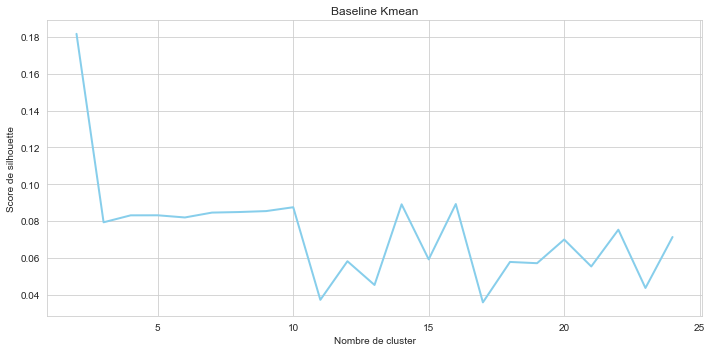

In [11]:
base_km_cluster_number = []
base_km_score = []
for n in range(2, 25):
    kmean = KMeans(n_clusters=n, n_init=100, max_iter=3000)
    kmean.fit(data_3_months_fe)
    base_km_cluster_number.append(n)
    base_km_score.append(silhouette_score(data_3_months_fe, kmean.labels_, metric='euclidean'))

plt.figure(figsize=(10, 5))
plt.plot(base_km_cluster_number, base_km_score, color="skyblue", lw=2)
plt.xlabel("Nombre de cluster")
plt.ylabel("Score de silhouette")
plt.title("Baseline Kmean")
plt.tight_layout()
plt.show()


### 4.2 - DBSCAN

In [12]:
dbscan_clust = DBSCAN(eps=0.8, min_samples=10)
dbscan_clust.fit(data_3_months_fe)

DBSCAN(algorithm='auto', eps=0.8, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=10, n_jobs=None, p=None)

In [13]:
dbscan_labels = dbscan_clust.labels_

In [14]:
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_clusters

19

In [15]:
silhouette_score(data_3_months_fe, dbscan_labels)

-0.35095667658863056

In [16]:
list(dbscan_labels).count(-1)

4506

### 4.3 - Clustering Hierarchique

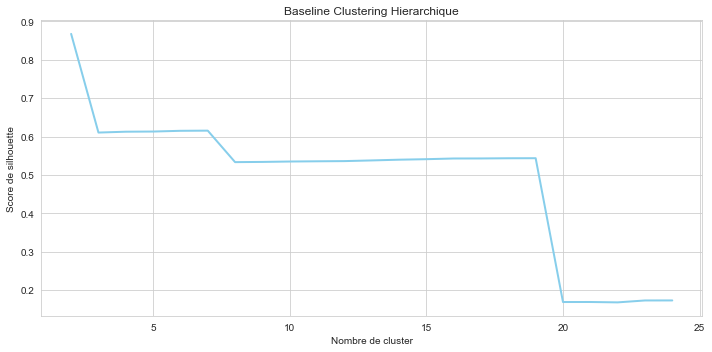

In [17]:
base_hier_cluster_number = []
base_hier_score = []
for n in range(2, 25):
    clust_hier = AgglomerativeClustering(n_clusters=n)
    clust_hier.fit(data_3_months_fe)
    base_hier_cluster_number.append(n)
    base_hier_score.append(silhouette_score(data_3_months_fe, clust_hier.labels_, metric="euclidean"))

plt.figure(figsize=(10, 5))
plt.plot(base_hier_cluster_number, base_hier_score, color="skyblue", lw=2)
plt.xlabel("Nombre de cluster")
plt.ylabel("Score de silhouette")
plt.title("Baseline Clustering Hierarchique")
plt.tight_layout()
plt.show()

## 5- Réduction de dimension

In [11]:
X = data_3_months_fe.values

### 5.1 - Linear PCA
#### 5.1.1 - Decomposition et projection

In [19]:
pca = decomposition.PCA(n_components=94)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=94, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

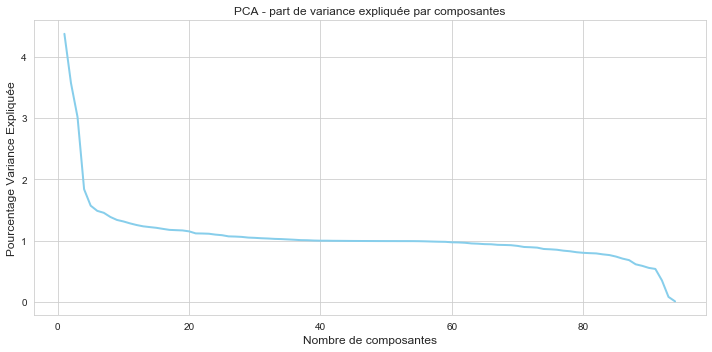

In [20]:
components = range(1, len(pca.explained_variance_ratio_) + 1)
plt.figure(figsize=(10, 5))
plt.plot(components, pca.explained_variance_ratio_*100, color='skyblue', lw=2)
plt.xlabel('Nombre de composantes', fontsize=12)
plt.ylabel('Pourcentage Variance Expliquée', fontsize=12)
plt.title('PCA - part de variance expliquée par composantes')
plt.tight_layout()
plt.show()

In [21]:
pca = decomposition.PCA(n_components=10)
pca.fit(X)

X_pca_projected = pca.transform(X)

#### 5.1.2 - Clustering
##### 5.1.2.1 - K-means

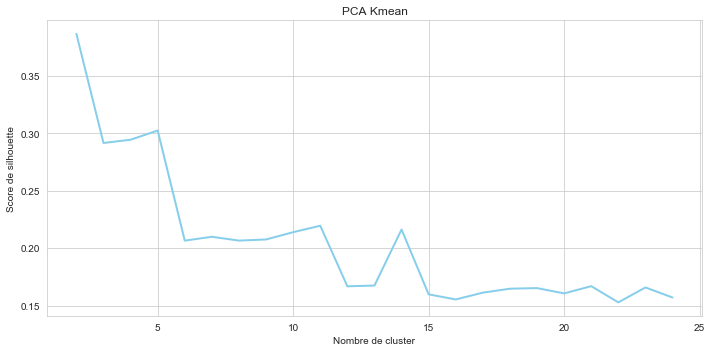

In [22]:
pca_km_cluster_number = []
pca_km_score = []
for n in range(2, 25):
    kmean = KMeans(n_clusters=n, n_init=100, max_iter=3000)
    kmean.fit(X_pca_projected)
    pca_km_cluster_number.append(n)
    pca_km_score.append(silhouette_score(X_pca_projected, kmean.labels_, metric='euclidean'))

plt.figure(figsize=(10, 5))
plt.plot(pca_km_cluster_number, pca_km_score, color="skyblue", lw=2)
plt.xlabel("Nombre de cluster")
plt.ylabel("Score de silhouette")
plt.title("PCA Kmean")
plt.tight_layout()
plt.show()


##### 5.1.2.2 - Clustering Hierarchique

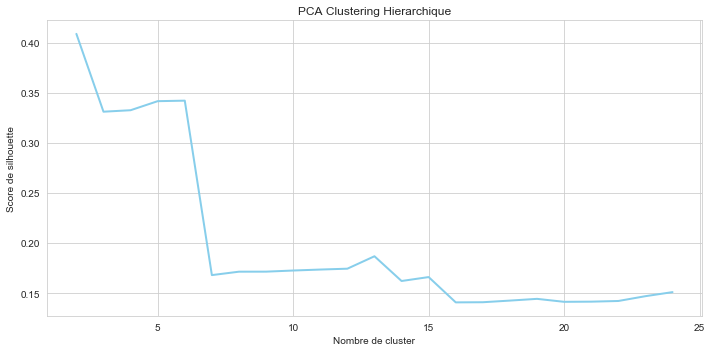

In [23]:
pca_hier_cluster_number = []
pca_hier_score = []
for n in range(2, 25):
    clust_hier = AgglomerativeClustering(n_clusters=n)
    clust_hier.fit(X_pca_projected)
    pca_hier_cluster_number.append(n)
    pca_hier_score.append(silhouette_score(X_pca_projected, clust_hier.labels_, metric="euclidean"))

plt.figure(figsize=(10, 5))
plt.plot(pca_hier_cluster_number, pca_hier_score, color="skyblue", lw=2)
plt.xlabel("Nombre de cluster")
plt.ylabel("Score de silhouette")
plt.title("PCA Clustering Hierarchique")
plt.tight_layout()
plt.show()

### 5.2 -  Kernel PCA
#### 5.2.1 - Decomposition et projection

In [24]:
kpca = decomposition.KernelPCA(n_components=101, kernel="cosine")
kpca.fit(X)

KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
          fit_inverse_transform=False, gamma=None, kernel='cosine',
          kernel_params=None, max_iter=None, n_components=101, n_jobs=None,
          random_state=None, remove_zero_eig=False, tol=0)

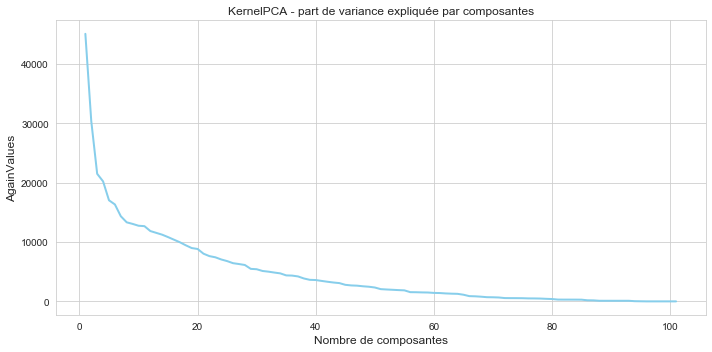

In [25]:
components = range(1, len(kpca.lambdas_)+1)
plt.figure(figsize=(10, 5))
plt.plot(components, kpca.lambdas_*100, color='skyblue', lw=2)
plt.xlabel('Nombre de composantes', fontsize=12)
plt.ylabel('AgainValues', fontsize=12)
plt.title('KernelPCA - part de variance expliquée par composantes')
plt.tight_layout()
plt.show()

In [26]:
kpca = decomposition.KernelPCA(n_components=10, kernel="cosine")
kpca.fit(X)

X_kpca_projected = kpca.transform(X)

#### 5.2.2 - Clustering
##### 5.2.2.1 - K-means

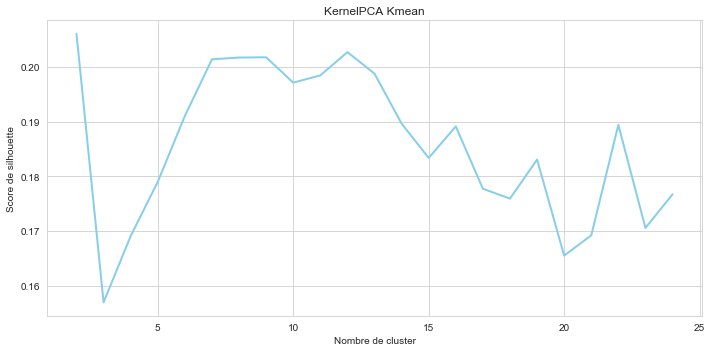

In [27]:
kpca_km_cluster_number = []
kpca_km_score = []
for n in range(2, 25):
    kmean = KMeans(n_clusters=n, n_init=100, max_iter=3000)
    kmean.fit(X_kpca_projected)
    kpca_km_cluster_number.append(n)
    kpca_km_score.append(silhouette_score(X_kpca_projected, kmean.labels_, metric='euclidean'))

plt.figure(figsize=(10, 5))
plt.plot(kpca_km_cluster_number, kpca_km_score, color="skyblue", lw=2)
plt.xlabel("Nombre de cluster")
plt.ylabel("Score de silhouette")
plt.title("KernelPCA Kmean")
plt.tight_layout()
plt.show()

##### 5.2.2.2 - Clustering Hierarchique

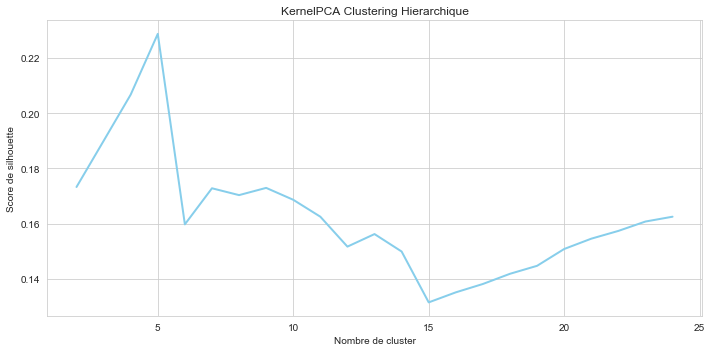

In [28]:
kpca_hier_cluster_number = []
kpca_hier_score = []
for n in range(2, 25):
    clust_hier = AgglomerativeClustering(n_clusters=n)
    clust_hier.fit(X_kpca_projected)
    kpca_hier_cluster_number.append(n)
    kpca_hier_score.append(silhouette_score(X_kpca_projected, clust_hier.labels_, metric="euclidean"))

plt.figure(figsize=(10, 5))
plt.plot(kpca_hier_cluster_number, kpca_hier_score, color="skyblue", lw=2)
plt.xlabel("Nombre de cluster")
plt.ylabel("Score de silhouette")
plt.title("KernelPCA Clustering Hierarchique")
plt.tight_layout()
plt.show()

### 5.3 - T-SNE
#### 5.3.1 - Decomposition et projection

In [29]:
tsne = manifold.TSNE(n_components=2, perplexity=70, n_iter=3000, random_state=0)
X_tsne = tsne.fit_transform(X)

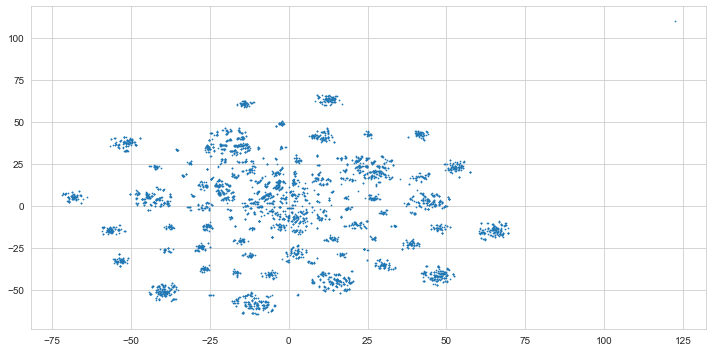

In [30]:
plt.figure(figsize=(10, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=0.5)
plt.tight_layout()
plt.show()

#### 5.3.2 - Clustering
##### 5.3.2.1 - K-means

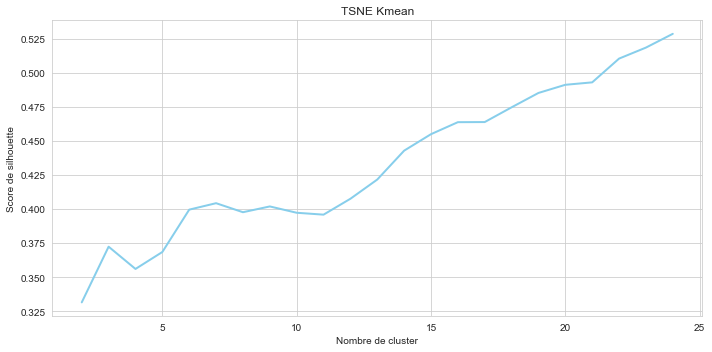

In [31]:
tsne_km_cluster_number = []
tsne_km_score = []
for n in range(2, 25):
    kmean = KMeans(n_clusters=n, n_init=100, max_iter=3000)
    kmean.fit(X_tsne)
    tsne_km_cluster_number.append(n)
    tsne_km_score.append(silhouette_score(X_tsne, kmean.labels_, metric='euclidean'))

plt.figure(figsize=(10, 5))
plt.plot(tsne_km_cluster_number, tsne_km_score, color="skyblue", lw=2)
plt.xlabel("Nombre de cluster")
plt.ylabel("Score de silhouette")
plt.title("TSNE Kmean")
plt.tight_layout()
plt.show()

##### 5.3.2.2 - Clustering Hierarchique

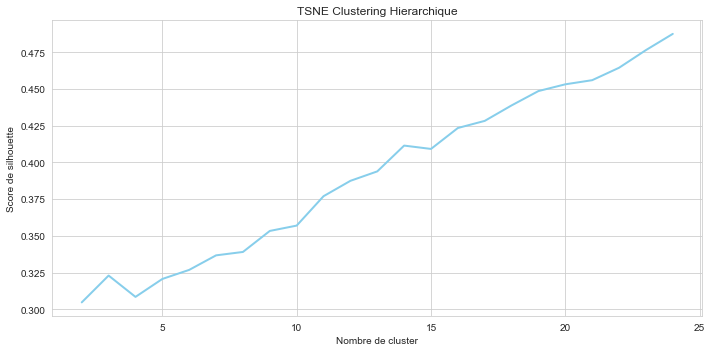

In [32]:
tsne_hier_cluster_number = []
tsne_hier_score = []
for n in range(2, 25):
    clust_hier = AgglomerativeClustering(n_clusters=n)
    clust_hier.fit(X_tsne)
    tsne_hier_cluster_number.append(n)
    tsne_hier_score.append(silhouette_score(X_tsne, clust_hier.labels_, metric="euclidean"))

plt.figure(figsize=(10, 5))
plt.plot(tsne_hier_cluster_number, tsne_hier_score, color="skyblue", lw=2)
plt.xlabel("Nombre de cluster")
plt.ylabel("Score de silhouette")
plt.title("TSNE Clustering Hierarchique")
plt.tight_layout()
plt.show()

### 5.4 - MDS
#### 5.4.1 - Decomposition et projection

In [33]:
mds = manifold.MDS(n_components=2, n_jobs=-1)
X_mds = mds.fit_transform(X)

#### 5.4.2 - Clustering
##### 5.4.2.1 - K-means

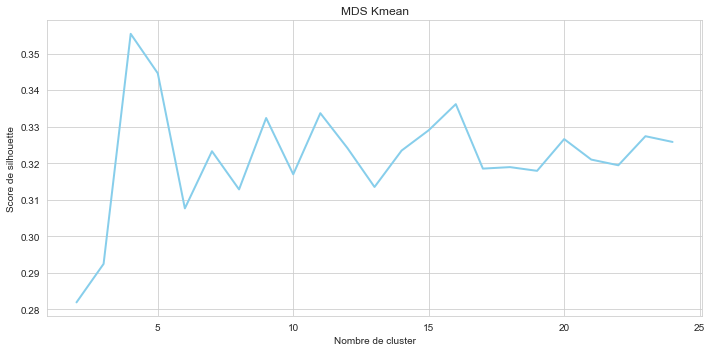

In [34]:
mds_km_cluster_number = []
mds_km_score = []
for n in range(2, 25):
    kmean = KMeans(n_clusters=n, n_init=100, max_iter=3000)
    kmean.fit(X_mds)
    mds_km_cluster_number.append(n)
    mds_km_score.append(silhouette_score(X_mds, kmean.labels_, metric='euclidean'))

plt.figure(figsize=(10, 5))
plt.plot(mds_km_cluster_number, mds_km_score, color="skyblue", lw=2)
plt.xlabel("Nombre de cluster")
plt.ylabel("Score de silhouette")
plt.title("MDS Kmean")
plt.tight_layout()
plt.show()

##### 5.4.2.2 - Clustering Hierarchique

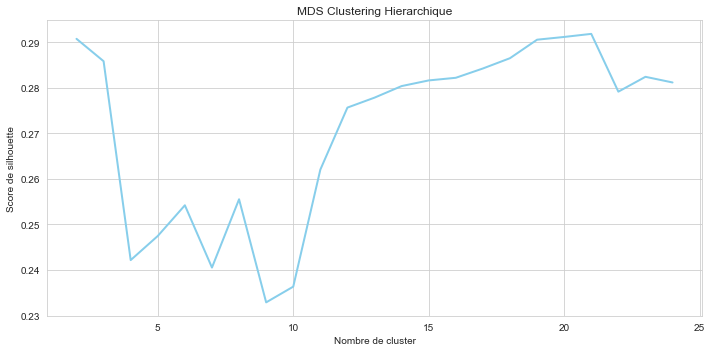

In [35]:
mds_hier_cluster_number = []
mds_hier_score = []
for n in range(2, 25):
    clust_hier = AgglomerativeClustering(n_clusters=n)
    clust_hier.fit(X_mds)
    mds_hier_cluster_number.append(n)
    mds_hier_score.append(silhouette_score(X_mds, clust_hier.labels_, metric="euclidean"))

plt.figure(figsize=(10, 5))
plt.plot(mds_hier_cluster_number, mds_hier_score, color="skyblue", lw=2)
plt.xlabel("Nombre de cluster")
plt.ylabel("Score de silhouette")
plt.title("MDS Clustering Hierarchique")
plt.tight_layout()
plt.show()

### 5.5 - ISO Map
#### 5.5.1 - Decomposition et projection

In [36]:
isomap = manifold.Isomap(n_components=2, n_jobs=-1)
X_isomap = isomap.fit_transform(X)

#### 5.5.2 - Clustering
##### 5.5.2.1 - K-means

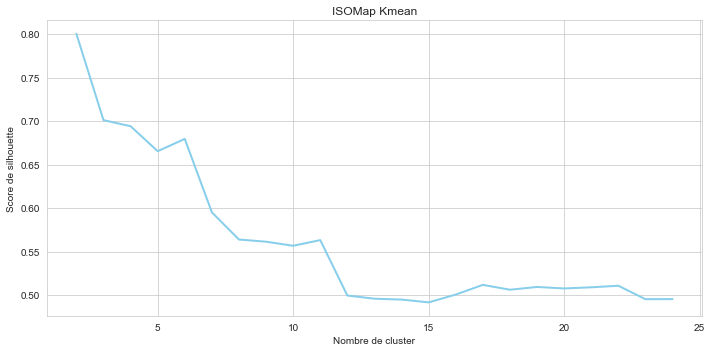

In [37]:
iso_km_cluster_number = []
iso_km_score = []
for n in range(2, 25):
    kmean = KMeans(n_clusters=n, n_init=100, max_iter=3000)
    kmean.fit(X_isomap)
    iso_km_cluster_number.append(n)
    iso_km_score.append(silhouette_score(X_isomap, kmean.labels_, metric='euclidean'))

plt.figure(figsize=(10, 5))
plt.plot(iso_km_cluster_number, iso_km_score, color="skyblue", lw=2)
plt.xlabel("Nombre de cluster")
plt.ylabel("Score de silhouette")
plt.title("ISOMap Kmean")
plt.tight_layout()
plt.show()

##### 5.5.2.2 - Clustering Hierarchique

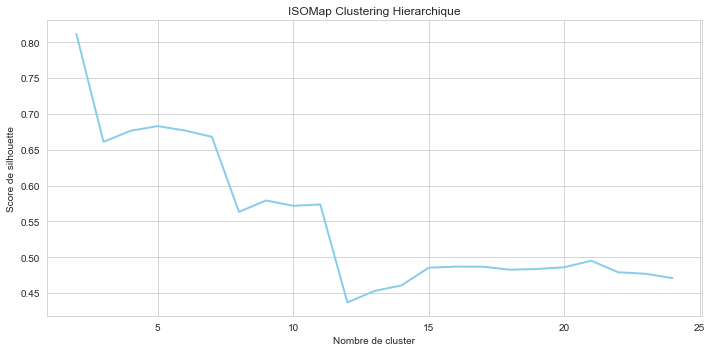

In [38]:
iso_hier_cluster_number = []
iso_hier_score = []
for n in range(2, 25):
    clust_hier = AgglomerativeClustering(n_clusters=n)
    clust_hier.fit(X_isomap)
    iso_hier_cluster_number.append(n)
    iso_hier_score.append(silhouette_score(X_isomap, clust_hier.labels_, metric="euclidean"))

plt.figure(figsize=(10, 5))
plt.plot(iso_hier_cluster_number, iso_hier_score, color="skyblue", lw=2)
plt.xlabel("Nombre de cluster")
plt.ylabel("Score de silhouette")
plt.title("ISOMap Clustering Hierarchique")
plt.tight_layout()
plt.show()

## 6 - Choix du meilleur modèle

In [12]:
# KernelPCA (10 composantes) puis KMeans avec 12 Clusters
kpca = decomposition.KernelPCA(n_components=10, kernel="cosine")
kpca.fit(X)

X_kpca_projected = kpca.transform(X)

In [13]:
kmean = KMeans(n_clusters=12, n_init=100, max_iter=3000)
kmean.fit(X_kpca_projected)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=3000,
       n_clusters=12, n_init=100, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [14]:
data_3_months_fe['cluster_kpca_km'] = kmean.labels_

In [15]:
# TSNE ( 2 composantes ) puis KMeans avec 15 Clusters
tsne = manifold.TSNE(n_components=2, perplexity=70, n_iter=3000, random_state=0)
X_tsne = tsne.fit_transform(X)

[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 4876 samples in 0.251s...
[t-SNE] Computed neighbors for 4876 samples in 5.448s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4876
[t-SNE] Computed conditional probabilities for sample 2000 / 4876
[t-SNE] Computed conditional probabilities for sample 3000 / 4876
[t-SNE] Computed conditional probabilities for sample 4000 / 4876
[t-SNE] Computed conditional probabilities for sample 4876 / 4876
[t-SNE] Mean sigma: 2.142806
[t-SNE] Computed conditional probabilities in 0.483s
[t-SNE] Iteration 50: error = 78.1184464, gradient norm = 0.0016863 (50 iterations in 3.455s)
[t-SNE] Iteration 100: error = 76.6849518, gradient norm = 0.0031446 (50 iterations in 3.061s)
[t-SNE] Iteration 150: error = 76.2807007, gradient norm = 0.0004650 (50 iterations in 2.970s)
[t-SNE] Iteration 200: error = 76.2586365, gradient norm = 0.0002087 (50 iterations in 2.948s)
[t-SNE] Iteration 250: error = 76.2516479, gradient norm = 0.000177

In [16]:
kmean_tsne = KMeans(n_clusters=15, n_init=100, max_iter=3000)
kmean_tsne.fit(X_tsne)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=3000,
       n_clusters=15, n_init=100, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [17]:
data_3_months_fe['cluster_tsne_km'] = kmean_tsne.labels_

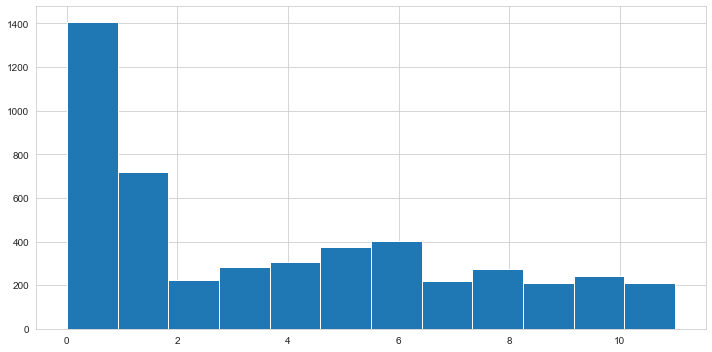

In [18]:
plt.figure(figsize=(10, 5))
plt.hist(data_3_months_fe['cluster_kpca_km'], bins=12)
plt.tight_layout()
plt.show()

In [19]:
print('taille cluster max: {}'.format(max(data_3_months_fe.groupby(['cluster_kpca_km']).size())))
print('taille cluster min: {}'.format(min(data_3_months_fe.groupby(['cluster_kpca_km']).size())))

taille cluster max: 1407
taille cluster min: 211


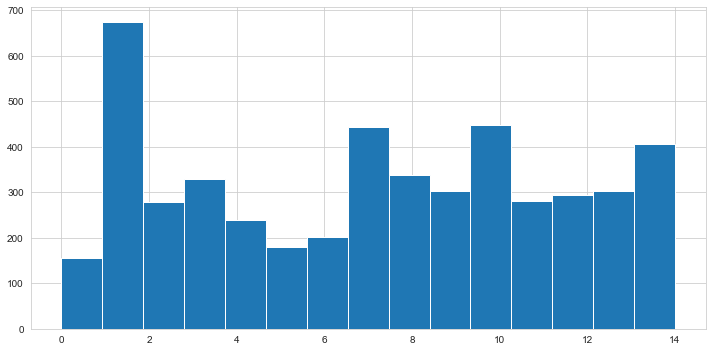

In [20]:
plt.figure(figsize=(10, 5))
plt.hist(data_3_months_fe['cluster_tsne_km'], bins=15)
plt.tight_layout()
plt.show()

In [21]:
print('taille cluster max: {}'.format(max(data_3_months_fe.groupby(['cluster_tsne_km']).size())))
print('taille cluster min: {}'.format(min(data_3_months_fe.groupby(['cluster_tsne_km']).size())))

taille cluster max: 674
taille cluster min: 155


La réduction de dimensions TSNE avec le modèle KMeans semble avoir une distribution plus équilibré, notre choix ce portera donc sur ce modèle et sur cette réduction de dimension.

In [22]:
data_3_months_fe = data_3_months_fe.drop(columns=['cluster_kpca_km'])

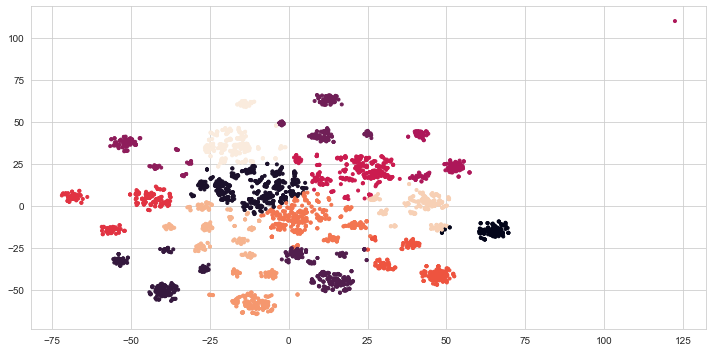

In [23]:
plt.figure(figsize=(10, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], marker='.', c=kmean_tsne.labels_)
plt.tight_layout()
plt.show()

In [24]:
from math import pi
categories = ["recency", "frequency", "monetary", "payment_value_mean", "review_score_mean"]
values = data_3_months_fe[categories].mean().values.flatten().tolist()
values += values[:1]

angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

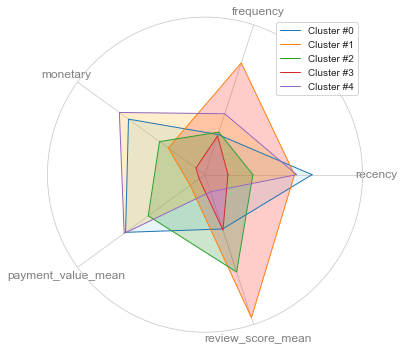

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), subplot_kw=(dict(polar=True)))

plt.xticks(angles[:-1], categories, color='grey', size=12)
plt.yticks(np.arange(1,6), ["1", "2", "3", "4", "5"], color='grey', size=12)
ax.set_rlabel_position(30)

# Cluster 0
val_c1 = data_3_months_fe.groupby("cluster_tsne_km").mean().loc[0][categories].tolist()
val_c1 += val_c1[:1]
ax.plot(angles, val_c1, linewidth=1, linestyle='solid', label='Cluster #0')
ax.fill(angles, val_c1, 'skyblue', alpha=0.2)
 
# Cluster 1
val_c2 = data_3_months_fe.groupby("cluster_tsne_km").mean().loc[1][categories].tolist()
val_c2 += val_c2[:1]
ax.plot(angles, val_c2, linewidth=1, linestyle='solid', label='Cluster #1')
ax.fill(angles, val_c2, 'red', alpha=0.2)
    
# Cluster 2
val_c3 = data_3_months_fe.groupby("cluster_tsne_km").mean().loc[2][categories].tolist()
val_c3 += val_c3[:1]
ax.plot(angles, val_c3, linewidth=1, linestyle='solid', label='Cluster #2')
ax.fill(angles, val_c3, 'green', alpha=0.2)

# Cluster 3
val_c4 = data_3_months_fe.groupby("cluster_tsne_km").mean().loc[3][categories].tolist()
val_c4 += val_c4[:1]
ax.plot(angles, val_c4, linewidth=1, linestyle='solid', label='Cluster #3')
ax.fill(angles, val_c4, 'magenta', alpha=0.2)
    
# Cluster 4
val_c5 = data_3_months_fe.groupby("cluster_tsne_km").mean().loc[4][categories].tolist()
val_c5 += val_c5[:1]
ax.plot(angles, val_c5, linewidth=1, linestyle='solid', label='Cluster #4')
ax.fill(angles, val_c5, 'orange', alpha=0.2)
    
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [26]:
data_result = pd.DataFrame(index=data_all_fe.index)

In [27]:
data_result['cluster_3_months'] = data_3_months_fe['cluster_tsne_km']
data_result

,cluster_3_months
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,NaN
0000b849f77a49e4a4ce2b2a4ca5be3f,NaN
0000f46a3911fa3c0805444483337064,2.0
0000f6ccb0745a6a4b88665a16c9f078,NaN
0004aac84e0df4da2b147fca70cf8255,NaN
...,...
fffcf5a5ff07b0908bd4e2dbc735a684,NaN
fffea47cd6d3cc0a88bd621562a9d061,NaN
ffff371b4d645b6ecea244b27531430a,10.0


## 7 - Clustering sur les autres jeux de données
### 7.1 - Normalisation

In [28]:
standardize = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)

In [29]:
standardize.fit(data_6_months_fe)
data_6_months_fe = standardize.transform(data_6_months_fe)

In [30]:
standardize.fit(data_9_months_fe)
data_9_months_fe = standardize.transform(data_9_months_fe)

In [31]:
standardize.fit(data_12_months_fe)
data_12_months_fe = standardize.transform(data_12_months_fe)

In [ ]:
standardize.fit(data_15_months_fe)
data_15_months_fe = standardize.transform(data_15_months_fe)

In [ ]:
standardize.fit(data_18_months_fe)
data_18_months_fe = standardize.transform(data_18_months_fe)

In [32]:
standardize.fit(data_all_fe)
data_all_fe = standardize.transform(data_all_fe)

### 7.2 - Réduction de dimension

In [33]:
X_6 = data_6_months_fe.values
X_9 = data_9_months_fe.values
X_12 = data_12_months_fe.values
X_15 = data_15_months_fe.values
X_18 = data_18_months_fe.values
X_all = data_all_fe.values

In [34]:
tsne = manifold.TSNE(n_components=2, perplexity=70, n_iter=3000, random_state=0)

In [35]:
X_6_tsne = tsne.fit_transform(X_6)

[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 13671 samples in 0.682s...
[t-SNE] Computed neighbors for 13671 samples in 36.136s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13671
[t-SNE] Computed conditional probabilities for sample 2000 / 13671
[t-SNE] Computed conditional probabilities for sample 3000 / 13671
[t-SNE] Computed conditional probabilities for sample 4000 / 13671
[t-SNE] Computed conditional probabilities for sample 5000 / 13671
[t-SNE] Computed conditional probabilities for sample 6000 / 13671
[t-SNE] Computed conditional probabilities for sample 7000 / 13671
[t-SNE] Computed conditional probabilities for sample 8000 / 13671
[t-SNE] Computed conditional probabilities for sample 9000 / 13671
[t-SNE] Computed conditional probabilities for sample 10000 / 13671
[t-SNE] Computed conditional probabilities for sample 11000 / 13671
[t-SNE] Computed conditional probabilities for sample 12000 / 13671
[t-SNE] Computed conditional probabilities for s

In [36]:
X_9_tsne = tsne.fit_transform(X_9)

[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 25575 samples in 1.210s...
[t-SNE] Computed neighbors for 25575 samples in 114.275s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25575
[t-SNE] Computed conditional probabilities for sample 2000 / 25575
[t-SNE] Computed conditional probabilities for sample 3000 / 25575
[t-SNE] Computed conditional probabilities for sample 4000 / 25575
[t-SNE] Computed conditional probabilities for sample 5000 / 25575
[t-SNE] Computed conditional probabilities for sample 6000 / 25575
[t-SNE] Computed conditional probabilities for sample 7000 / 25575
[t-SNE] Computed conditional probabilities for sample 8000 / 25575
[t-SNE] Computed conditional probabilities for sample 9000 / 25575
[t-SNE] Computed conditional probabilities for sample 10000 / 25575
[t-SNE] Computed conditional probabilities for sample 11000 / 25575
[t-SNE] Computed conditional probabilities for sample 12000 / 25575
[t-SNE] Computed conditional probabilities for 

In [37]:
X_12_tsne = tsne.fit_transform(X_12)

[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 42403 samples in 6.571s...
[t-SNE] Computed neighbors for 42403 samples in 292.425s...
[t-SNE] Computed conditional probabilities for sample 1000 / 42403
[t-SNE] Computed conditional probabilities for sample 2000 / 42403
[t-SNE] Computed conditional probabilities for sample 3000 / 42403
[t-SNE] Computed conditional probabilities for sample 4000 / 42403
[t-SNE] Computed conditional probabilities for sample 5000 / 42403
[t-SNE] Computed conditional probabilities for sample 6000 / 42403
[t-SNE] Computed conditional probabilities for sample 7000 / 42403
[t-SNE] Computed conditional probabilities for sample 8000 / 42403
[t-SNE] Computed conditional probabilities for sample 9000 / 42403
[t-SNE] Computed conditional probabilities for sample 10000 / 42403
[t-SNE] Computed conditional probabilities for sample 11000 / 42403
[t-SNE] Computed conditional probabilities for sample 12000 / 42403
[t-SNE] Computed conditional probabilities for 

In [ ]:
X_15_tsne = tsne.fit_transform(X_15)

In [ ]:
X_18_tsne = tsne.fit_transform(X_18)

In [38]:
X_all_tsne = tsne.fit_transform(X_all)

[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 93790 samples in 39.442s...
[t-SNE] Computed neighbors for 93790 samples in 1200.528s...
[t-SNE] Computed conditional probabilities for sample 1000 / 93790
[t-SNE] Computed conditional probabilities for sample 2000 / 93790
[t-SNE] Computed conditional probabilities for sample 3000 / 93790
[t-SNE] Computed conditional probabilities for sample 4000 / 93790
[t-SNE] Computed conditional probabilities for sample 5000 / 93790
[t-SNE] Computed conditional probabilities for sample 6000 / 93790
[t-SNE] Computed conditional probabilities for sample 7000 / 93790
[t-SNE] Computed conditional probabilities for sample 8000 / 93790
[t-SNE] Computed conditional probabilities for sample 9000 / 93790
[t-SNE] Computed conditional probabilities for sample 10000 / 93790
[t-SNE] Computed conditional probabilities for sample 11000 / 93790
[t-SNE] Computed conditional probabilities for sample 12000 / 93790
[t-SNE] Computed conditional probabilities fo

### 7.3 - Clustering

Jeux de donnée : data_6_months

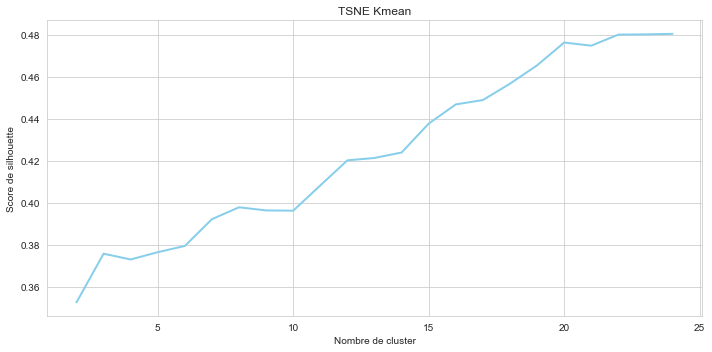

In [39]:
tsne_km_cluster_number = []
tsne_km_score = []
for n in range(2, 25):
    kmean = KMeans(n_clusters=n, n_init=100, max_iter=3000)
    kmean.fit(X_6_tsne)
    tsne_km_cluster_number.append(n)
    tsne_km_score.append(silhouette_score(X_6_tsne, kmean.labels_, metric='euclidean'))

plt.figure(figsize=(10, 5))
plt.plot(tsne_km_cluster_number, tsne_km_score, color="skyblue", lw=2)
plt.xlabel("Nombre de cluster")
plt.ylabel("Score de silhouette")
plt.title("TSNE Kmean")
plt.tight_layout()
plt.show()

In [84]:
kmean_tsne = KMeans(n_clusters=16, n_init=100, max_iter=3000)
kmean_tsne.fit(X_6_tsne)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=3000,
       n_clusters=16, n_init=100, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [85]:
data_6_months_fe['cluster_tsne_km'] = kmean_tsne.labels_

Jeux de donnée : data_9_months

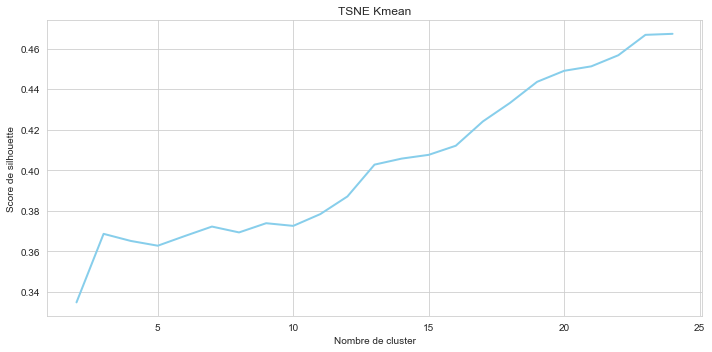

In [42]:
tsne_km_cluster_number = []
tsne_km_score = []
for n in range(2, 25):
    kmean = KMeans(n_clusters=n, n_init=100, max_iter=3000)
    kmean.fit(X_9_tsne)
    tsne_km_cluster_number.append(n)
    tsne_km_score.append(silhouette_score(X_9_tsne, kmean.labels_, metric='euclidean'))

plt.figure(figsize=(10, 5))
plt.plot(tsne_km_cluster_number, tsne_km_score, color="skyblue", lw=2)
plt.xlabel("Nombre de cluster")
plt.ylabel("Score de silhouette")
plt.title("TSNE Kmean")
plt.tight_layout()
plt.show()

In [86]:
kmean_tsne = KMeans(n_clusters=17, n_init=100, max_iter=3000)
kmean_tsne.fit(X_9_tsne)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=3000,
       n_clusters=17, n_init=100, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [87]:
data_9_months_fe['cluster_tsne_km'] = kmean_tsne.labels_

Jeux de donnée : data_12_months

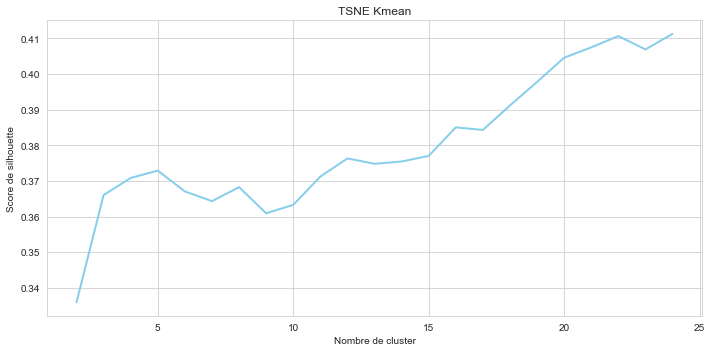

In [45]:
tsne_km_cluster_number = []
tsne_km_score = []
for n in range(2, 25):
    kmean = KMeans(n_clusters=n, n_init=100, max_iter=3000)
    kmean.fit(X_12_tsne)
    tsne_km_cluster_number.append(n)
    tsne_km_score.append(silhouette_score(X_12_tsne, kmean.labels_, metric='euclidean'))

plt.figure(figsize=(10, 5))
plt.plot(tsne_km_cluster_number, tsne_km_score, color="skyblue", lw=2)
plt.xlabel("Nombre de cluster")
plt.ylabel("Score de silhouette")
plt.title("TSNE Kmean")
plt.tight_layout()
plt.show()

In [47]:
kmean_tsne = KMeans(n_clusters=16, n_init=100, max_iter=3000)
kmean_tsne.fit(X_12_tsne)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=3000,
       n_clusters=16, n_init=100, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [48]:
data_12_months_fe['cluster_tsne_km'] = kmean_tsne.labels_

Jeux de donnée : data_15_months

In [ ]:
tsne_km_cluster_number = []
tsne_km_score = []
for n in range(2, 25):
    kmean = KMeans(n_clusters=n, n_init=100, max_iter=3000)
    kmean.fit(X_15_tsne)
    tsne_km_cluster_number.append(n)
    tsne_km_score.append(silhouette_score(X_15_tsne, kmean.labels_, metric='euclidean'))

plt.figure(figsize=(10, 5))
plt.plot(tsne_km_cluster_number, tsne_km_score, color="skyblue", lw=2)
plt.xlabel("Nombre de cluster")
plt.ylabel("Score de silhouette")
plt.title("TSNE Kmean")
plt.tight_layout()
plt.show()

In [ ]:
kmean_tsne = KMeans(n_clusters=17, n_init=100, max_iter=3000)
kmean_tsne.fit(X_15_tsne)

In [ ]:
data_15_months_fe['cluster_tsne_km'] = kmean_tsne.labels_

Jeux de donnée : data_18_months

In [ ]:
tsne_km_cluster_number = []
tsne_km_score = []
for n in range(2, 25):
    kmean = KMeans(n_clusters=n, n_init=100, max_iter=3000)
    kmean.fit(X_18_tsne)
    tsne_km_cluster_number.append(n)
    tsne_km_score.append(silhouette_score(X_18_tsne, kmean.labels_, metric='euclidean'))

plt.figure(figsize=(10, 5))
plt.plot(tsne_km_cluster_number, tsne_km_score, color="skyblue", lw=2)
plt.xlabel("Nombre de cluster")
plt.ylabel("Score de silhouette")
plt.title("TSNE Kmean")
plt.tight_layout()
plt.show()

In [ ]:
kmean_tsne = KMeans(n_clusters=17, n_init=100, max_iter=3000)
kmean_tsne.fit(X_18_tsne)

In [ ]:
data_18_months_fe['cluster_tsne_km'] = kmean_tsne.labels_

Jeux de donnée : data_all

In [ ]:
tsne_km_cluster_number = []
tsne_km_score = []
for n in range(2, 25):
    kmean = KMeans(n_clusters=n, n_init=100, max_iter=3000)
    kmean.fit(X_all_tsne)
    tsne_km_cluster_number.append(n)
    tsne_km_score.append(silhouette_score(X_all_tsne, kmean.labels_, metric='euclidean'))

plt.figure(figsize=(10, 5))
plt.plot(tsne_km_cluster_number, tsne_km_score, color="skyblue", lw=2)
plt.xlabel("Nombre de cluster")
plt.ylabel("Score de silhouette")
plt.title("TSNE Kmean")
plt.tight_layout()
plt.show()

In [66]:
kmean_tsne = KMeans(n_clusters=17, n_init=100, max_iter=3000)
kmean_tsne.fit(X_all_tsne)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=3000,
       n_clusters=17, n_init=100, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [67]:
data_all_fe['cluster_tsne_km'] = kmean_tsne.labels_

## 8 - Analyse des résultats

In [88]:
data_result['cluster_6_months'] = data_6_months_fe['cluster_tsne_km']
data_result['cluster_9_months'] = data_9_months_fe['cluster_tsne_km']
data_result['cluster_12_months'] = data_12_months_fe['cluster_tsne_km']
data_result['cluster_15_months'] = data_15_months_fe['cluster_tsne_km']
data_result['cluster_18_months'] = data_18_months_fe['cluster_tsne_km']
data_result['cluster_all'] = data_all_fe['cluster_tsne_km']

In [89]:
data_result

,cluster_3_months,cluster_6_months,cluster_9_months,cluster_12_months,cluster_all
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,NaN,NaN,NaN,NaN,11
0000b849f77a49e4a4ce2b2a4ca5be3f,NaN,NaN,NaN,NaN,9
0000f46a3911fa3c0805444483337064,2.0,15.0,11.0,1.0,1
0000f6ccb0745a6a4b88665a16c9f078,NaN,NaN,NaN,13.0,7
0004aac84e0df4da2b147fca70cf8255,NaN,NaN,NaN,11.0,7
...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,NaN,12.0,8.0,6.0,2
fffea47cd6d3cc0a88bd621562a9d061,NaN,NaN,NaN,10.0,5
ffff371b4d645b6ecea244b27531430a,10.0,3.0,5.0,15.0,0


In [103]:
data_based_3_months = data_result[:][data_result["cluster_3_months"].notnull()]

In [117]:
data_frequency = pd.DataFrame(index=["AMI Score", 'AR Score'])

In [123]:
AMI_3_months = metrics.adjusted_mutual_info_score(data_based_3_months["cluster_3_months"], 
                                                  data_based_3_months["cluster_3_months"], 
                                                  average_method='arithmetic')
AR_3_months = metrics.adjusted_rand_score(data_based_3_months["cluster_3_months"], 
                                          data_based_3_months["cluster_3_months"])
NMI_3_months = metrics.normalized_mutual_info_score(data_based_3_months["cluster_3_months"], 
                                                    data_based_3_months["cluster_3_months"], 
                                                    average_method='arithmetic')


AMI_6_months = metrics.adjusted_mutual_info_score(data_based_3_months["cluster_3_months"], 
                                                  data_based_3_months["cluster_6_months"], 
                                                  average_method='arithmetic')
AR_6_months = metrics.adjusted_rand_score(data_based_3_months["cluster_3_months"], 
                                          data_based_3_months["cluster_6_months"])
NMI_6_months = metrics.normalized_mutual_info_score(data_based_3_months["cluster_3_months"], 
                                                    data_based_3_months["cluster_6_months"], 
                                                    average_method='arithmetic')


AMI_9_months = metrics.adjusted_mutual_info_score(data_based_3_months["cluster_3_months"],
                                                  data_based_3_months["cluster_9_months"], 
                                                  average_method="arithmetic")
AR_9_months = metrics.adjusted_rand_score(data_based_3_months["cluster_3_months"], 
                                          data_based_3_months["cluster_9_months"])
NMI_9_months = metrics.normalized_mutual_info_score(data_based_3_months["cluster_3_months"], 
                                                    data_based_3_months["cluster_9_months"], 
                                                    average_method='arithmetic')


AMI_12_months = metrics.adjusted_mutual_info_score(data_based_3_months["cluster_3_months"],
                                                   data_based_3_months["cluster_12_months"],
                                                   average_method="arithmetic")
AR_12_months = metrics.adjusted_rand_score(data_based_3_months["cluster_3_months"], 
                                           data_based_3_months["cluster_12_months"])
NMI_12_months = metrics.normalized_mutual_info_score(data_based_3_months["cluster_3_months"], 
                                                    data_based_3_months["cluster_12_months"], 
                                                    average_method='arithmetic')

AMI_15_months = metrics.adjusted_mutual_info_score(data_based_3_months["cluster_3_months"],
                                                   data_based_3_months["cluster_15_months"],
                                                   average_method="arithmetic")
AR_15_months = metrics.adjusted_rand_score(data_based_3_months["cluster_3_months"], 
                                           data_based_3_months["cluster_15_months"])
NMI_15_months = metrics.normalized_mutual_info_score(data_based_3_months["cluster_3_months"], 
                                                    data_based_3_months["cluster_15_months"], 
                                                    average_method='arithmetic')


AMI_18_months = metrics.adjusted_mutual_info_score(data_based_3_months["cluster_3_months"],
                                                   data_based_3_months["cluster_18_months"],
                                                   average_method="arithmetic")
AR_18_months = metrics.adjusted_rand_score(data_based_3_months["cluster_3_months"], 
                                           data_based_3_months["cluster_18_months"])
NMI_18_months = metrics.normalized_mutual_info_score(data_based_3_months["cluster_3_months"], 
                                                    data_based_3_months["cluster_18_months"], 
                                                    average_method='arithmetic')


AMI_all = metrics.adjusted_mutual_info_score(data_based_3_months["cluster_3_months"],
                                             data_based_3_months["cluster_all"],
                                             average_method="arithmetic")
AR_all = metrics.adjusted_rand_score(data_based_3_months["cluster_3_months"], 
                                     data_based_3_months["cluster_all"])
NMI_all = metrics.normalized_mutual_info_score(data_based_3_months["cluster_3_months"], 
                                                    data_based_3_months["cluster_all"], 
                                                    average_method='arithmetic')

In [124]:
data_frequency.loc["AMI Score", "cluster_3_months"] = AMI_3_months
data_frequency.loc["AMI Score","cluster_6_months"] = AMI_6_months
data_frequency.loc["AMI Score","cluster_9_months"] = AMI_9_months
data_frequency.loc["AMI Score","cluster_12_months"] = AMI_12_months
data_frequency.loc["AMI Score","cluster_15_months"] = AMI_15_months
data_frequency.loc["AMI Score","cluster_18_months"] = AMI_18_months
data_frequency.loc["AMI Score","cluster_all"] = AMI_all

data_frequency.loc["AR Score", "cluster_3_months"] = AR_3_months
data_frequency.loc["AR Score", "cluster_6_months"] = AR_6_months
data_frequency.loc["AR Score", "cluster_9_months"] = AR_9_months
data_frequency.loc["AR Score", "cluster_12_months"] = AR_12_months
data_frequency.loc["AR Score", "cluster_15_months"] = AR_15_months
data_frequency.loc["AR Score", "cluster_18_months"] = AR_18_months
data_frequency.loc["AR Score", "cluster_all"] = AR_all

data_frequency.loc["NMI Score", "cluster_3_months"] = NMI_3_months
data_frequency.loc["NMI Score", "cluster_6_months"] = NMI_6_months
data_frequency.loc["NMI Score", "cluster_9_months"] = NMI_9_months
data_frequency.loc["NMI Score", "cluster_12_months"] = NMI_12_months
data_frequency.loc["NMI Score", "cluster_15_months"] = NMI_15_months
data_frequency.loc["NMI Score", "cluster_18_months"] = NMI_18_months
data_frequency.loc["NMI Score", "cluster_all"] = NMI_all

In [125]:
data_frequency

,cluster_3_months,cluster_6_months,cluster_9_months,cluster_12_months,cluster_all
AMI Score,1.0,0.562564,0.558831,0.517139,0.417643
AR Score,1.0,0.371377,0.376489,0.324934,0.213621
NMI Score,1.0,0.566115,0.562629,0.521054,0.422628
